<a href="https://colab.research.google.com/github/ronaldnunes/Fruits-classification-w-pytorch/blob/main/FruitsCNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARREGANDO AS BIBLIOTECAS

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from google.colab import files

# PRÉ-PROCESSAMENTO DAS IMAGENS


IMPORTANDO O DATASET

In [ ]:
# Faça o upload do arquivo Fruits360.zip do seu computador (disponível para baixar no repositório)
uploaded = files.upload()

In [ ]:
try:
  !unzip /content/drive/MyDrive/Fruits360_20.zip

except:
  !unzip Fruits360_20.zip

DEFININDO O CAMINHO DAS PASTAS DE TREINO E TESTE

In [4]:
path_train = "/content/Fruits360/training"
path_test = "/content/Fruits360/test"

DATA AUGMENTATION E TRANSFORMAÇÕES NECESSÁRIAS


In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),           # Inverte horizontalmente aleatoriamente (data augmentation)
    transforms.RandomRotation(15),              # Rotação aleatória de até 15 graus(data augmentation)
    transforms.Resize((64, 64)),                   # Redimensiona as imagens
    transforms.ToTensor(),                      # Converte para tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza os valores para tornar o treinamento mais eficiente
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensiona as imagens
    transforms.ToTensor(),       # Converte para tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza os valores para tornar o treinamento mais eficiente
])

CARREGANDO OS DADOS E APLICANDO AS TRANSFORMAÇÕES

In [6]:
data_train = datasets.ImageFolder(path_train, transform = train_transform)
data_test = datasets.ImageFolder(path_test, transform = test_transform)

CARREGANDO OS NOVOS DADOS EM LOTES E EMBARALHANDO

In [7]:
train_loader = DataLoader(data_train, batch_size=96, shuffle=True)
test_loader = DataLoader(data_test, batch_size=96, shuffle=True)

#FUNÇÕES AUXILIARES

FUNÇÃO DE TREINAMENTO

In [8]:
def Train(model, dataloader, loss_function, optimizer):
    """
    Treina o modelo usando os dados fornecidos pelo dataloader.

    Parâmetros:
        model: O modelo a ser treinado.
        dataloader: Dataloader com os dados de treinamento.
        loss_function: Função de perda usada para calcular o erro.
        optimizer: Otimizador usado para ajustar os pesos do modelo.

    Retorna:
        O erro médio (loss) de todas as iterações no dataloader.
    """
    model.train() #coloca o modelo em modo de treinamento
    total_loss = 0.0
    for imgs, labels in dataloader:
      #extrai as imagens e os rotulos do loader
      imgs, labels = imgs.to(device), labels.to(device)

      optimizer.zero_grad() #zera os gradientes

      pred = model(imgs) #passa as imagens para o modelo prever

      loss = loss_function(pred, labels) #calcula a loss
      loss.backward() #calcula os gradientes(backpropagation)
      optimizer.step() #atualiza os pesos do modelo

      total_loss += loss.item() #soma o erro atual à soma dos erros

    return total_loss / len(dataloader) # retorna o custo de treino

FUNÇÃO DE VALIDAÇAO


In [9]:
def Validate(model, dataloader, loss_function):
  """
    Avalia o desempenho do modelo no conjunto de dados de teste fornecido.

    Parâmetros:
        model: O modelo a ser avaliado.
        dataloader: Dataloader com os dados de teste.
        loss_function: Função de perda usada para calcular o erro.

    Retorna:
        O erro médio (loss) no conjunto de validação.
    """

  model.eval()  # coloca o modelo em modo de avaliação
  total_loss = 0.0

  with torch.no_grad(): #desabilita o calculo dos gradientes
    for imgs, labels in dataloader:
      #extrai as imagens e os rotulos do loader
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs) #passa as imagens para o modelo prever
      loss = loss_function(pred, labels) #calcula a loss
      total_loss += loss.item()  #soma o erro atual à soma dos erros

  return total_loss / len(dataloader) # retorna o custo de teste

FUNÇÃO PARA CALCULAR MÉTRICAS

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score
def Metrics(model, test_loader):
  """
    Avalia a acurácia do modelo no conjunto de dados de teste.

    Parâmetros:
        model: O modelo a ser avaliado.
        test_loader: Dataloader com os dados de teste.

    Retorna:
        A função imprime a acurácia no conjunto de teste.
    """
  model.eval() # coloca o modelo em modo de avaliação
  all_labels = []
  all_preds = []
  correct = 0
  total = 0


  with torch.no_grad():    # desabilita o calculo dos gradientes
      for data in test_loader:
        # extrai as imagens e os rotulos do loader
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          outputs = model(images) # passa as imagens para o modelo prever
          pred = torch.argmax(outputs, 1) # retorna a classe prevista

          total += labels.size(0) # atualizando o numero de amostras processadas
          correct += (pred == labels).sum().item() # atualizando o numero de previsões corretas

          all_labels.extend(labels.cpu().numpy())  # Converte para numpy e salva
          all_preds.extend(pred.cpu().numpy())


  precision = precision_score(all_labels, all_preds, average='weighted')
  recall = recall_score(all_labels, all_preds, average='weighted')
  f1 = f1_score(all_labels, all_preds, average='weighted')
  accuracy = correct / total

  print(f"Acurácia no conjunto de teste: {accuracy:.4f}")
  print(f"Precisão no conjunto de teste: {precision:.4f}")
  print(f"Recall no conjunto de teste: {recall:.4f}")
  print(f"F1 Score no conjunto de teste: {f1:.4f}")

FUNÇÃO DE PREDIÇÃO

In [11]:
def Predict(model, dataloader, classes = data_test.classes, num_imagens=6):
    """
      Realiza previsões com o modelo e exibe as imagens com os rotulos reais e preditos.

      Parâmetros:
          model: O modelo a ser usado para fazer as previsões.
          dataloader: Dataloader com os dados para predição.
          classes: Lista com os nomes das classes. O padrão é 'data_test.classes'.
          num_imagens: Número de imagens a serem exibidas. O padrão é 6.

      Retorna:
          A função exibe as imagens com as predições.
      """

    model.eval()  # coloca o modelo em modo de avaliação

    imagens_exibidas = 0

    plt.figure(figsize=(12, 8)) #cria uma figura para exibir as imagens

    with torch.no_grad(): #desativa o calculo dos gradientes

      for images, labels in dataloader:
        #extrai as imagens e os rotulos do loader
            images, labels = images.to(device), labels.to(device)

            outputs = model(images) #passa as imagens para o modelo prever
            pred = torch.argmax(outputs, 1) #retorna a classe prevista

            for i in range(images.size(0)): #itera sobre as imagens na batch
                if imagens_exibidas == num_imagens:
                    plt.show() #mostra as imagens
                    return


                plt.subplot(2, 3, imagens_exibidas + 1) #cria um subgrafico
                plt.axis('off') #desativa os eixos do subgrafico
                plt.imshow(images[i].permute(1, 2, 0).cpu().numpy()) #exibe a imagem
                plt.title(f"Real: {classes[labels[i]]}\nPred: {classes[pred[i]]}",
                          color="green" if pred[i] == labels[i] else "red") #define o titulo e as cores
                imagens_exibidas += 1 #adiciona 1 à imagens exibidas

FUNÇÃO PARA PLOTAR A CURVA DE APRENDIZADO

In [12]:
def LearningCurve(errors):
    """
    Plota a curva de aprendizado com base nos erros de treinamento e validação.

    Parâmetros:
        errors: Dicionário contendo os valores de erro para diferentes nomes de erro.
         As chaves são os nomes dos erros
         e os valores são listas com os erros ao longo das iterações.

    Retorna:
        A função exibe um gráfico com a curva de aprendizado.
    """
    fig = plt.figure(figsize=(13, 5))  # cria uma figura para o gráfico com tamanho 13x5 polegadas
    ax = fig.gca() #obtem os eixos da figura
    for loss_name, loss_values in errors.items(): #itera sobre o nome dos erros e seus valores
      ax.plot(loss_values, label=loss_name) #plota os valores dos erros
    ax.legend(fontsize="16") # adiciona uma legenda
    ax.set_xlabel("Iteração", fontsize="16") # define o rotulo do eixo x
    ax.set_ylabel("Erro", fontsize="16") # define o rotulo do eixo y
    ax.set_title("Curva da Aprendizado", fontsize="16"); # define o titulo

# CONSTRUINDO UMA REDE CONVOLUCIONAL

DEFININDO A ARQUITETURA DA REDE

In [13]:
class ConvNet(nn.Module): # cria uma classe
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(32 * 16 * 16, 128),
        nn.ReLU(),
        nn.Linear(128, len(data_train.classes))
    )

  def forward(self, x): # define como os dados vão passar atraves das camadas
    return self.layers(x) #retorna a sequencia de camadas definidas anteriormente



In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu" #definindo o dispositivo
convnet = ConvNet().to(device)

loss_function = nn.CrossEntropyLoss()  # Definindo a função de perda (Entropia Cruzada)
optimizer = torch.optim.SGD(convnet.parameters(), lr=0.001, momentum = 0.1)  # Definindo o otimizador (SGD)

# TREINAMENTO, MÉTRICAS E PREDIÇÕES

TREINAMENTO


In [24]:
epochs = 101 # numero de iteracoes
train_costs = [] # lista com o custo de treino para cada iteração
test_costs = [] # lista com o custo de teste para cada iteração
for t in range(epochs):

  train_cost = Train(convnet, train_loader, loss_function, optimizer)
  train_costs.append(train_cost)

  test_cost = Validate(convnet, test_loader, loss_function)
  test_costs.append(test_cost)

  print(f"Epoch: {t}; Train Loss: {train_cost}")

print("FIM")


Epoch: 0; Train Loss: 3.17773534213343
Epoch: 1; Train Loss: 3.1629189368217223
Epoch: 2; Train Loss: 3.1458908915519714
Epoch: 3; Train Loss: 3.123006711083074
Epoch: 4; Train Loss: 3.086525055669969
Epoch: 5; Train Loss: 3.0256442831408594
Epoch: 6; Train Loss: 2.9253369589005747
Epoch: 7; Train Loss: 2.7799130928131843
Epoch: 8; Train Loss: 2.579334105214765
Epoch: 9; Train Loss: 2.308475967376463
Epoch: 10; Train Loss: 1.9902240864692196
Epoch: 11; Train Loss: 1.6691192013602103
Epoch: 12; Train Loss: 1.3819702738715756
Epoch: 13; Train Loss: 1.1475667280535544
Epoch: 14; Train Loss: 0.9574489175311981
Epoch: 15; Train Loss: 0.8074174297432746
Epoch: 16; Train Loss: 0.6841103417738792
Epoch: 17; Train Loss: 0.5903039766896155
Epoch: 18; Train Loss: 0.5058924440414675
Epoch: 19; Train Loss: 0.44298507946152843
Epoch: 20; Train Loss: 0.38600005089275297
Epoch: 21; Train Loss: 0.34169226896858984
Epoch: 22; Train Loss: 0.3018283213098203
Epoch: 23; Train Loss: 0.26959671032044197
Epoc

CURVA DE APRENDIZADO

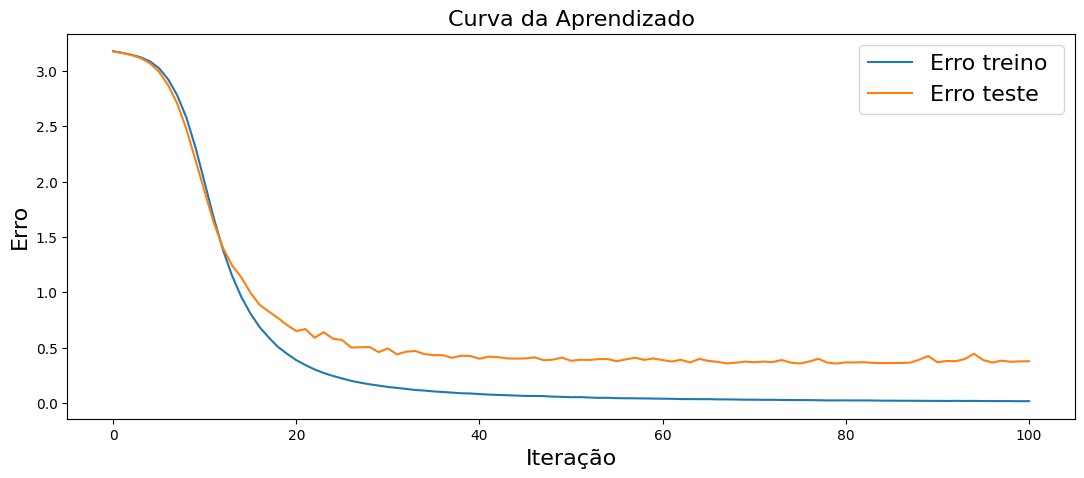

In [25]:
errors = {"Erro treino ": train_costs, "Erro teste": test_costs}
LearningCurve(errors)

ACURÁCIA

In [26]:
Metrics(convnet, test_loader)

Acurácia no conjunto de teste: 0.9543
Precisão no conjunto de teste: 0.9616
Recall no conjunto de teste: 0.9543
F1 Score no conjunto de teste: 0.9519


PREVISÕES COM IMAGENS NO CONJUNTO DE TESTE

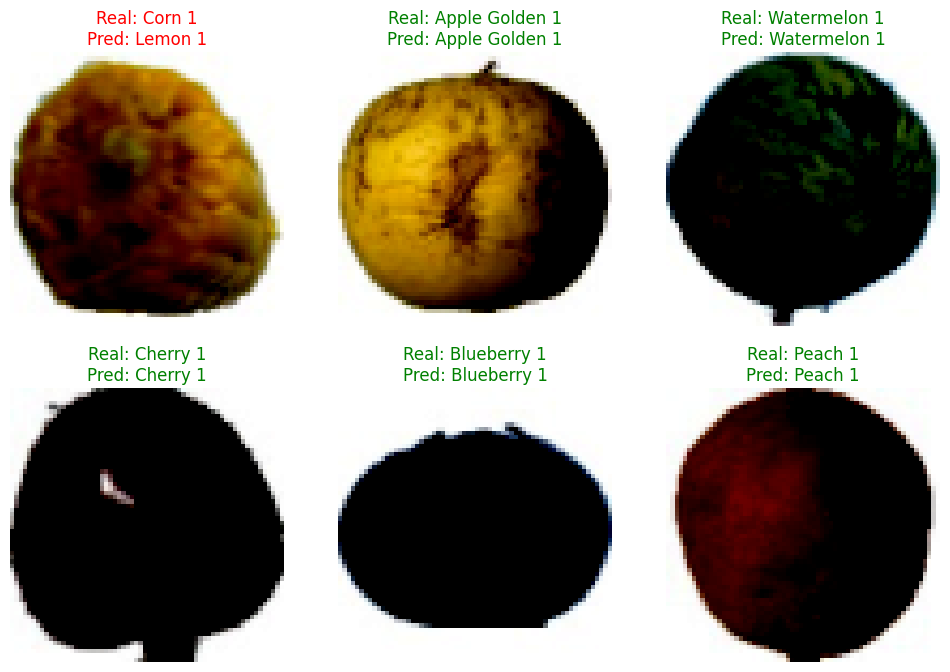

In [27]:
Predict(convnet, test_loader, num_imagens = 6)